<a href="https://colab.research.google.com/github/danielbehargithub/LinkedIn_Salary/blob/main/Salary/Salary_Reduce_Categories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lightgbm
!pip install --upgrade lightgbm
!pip install pycountry_convert
!pip install "dask[dataframe]"


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.cluster import MiniBatchKMeans
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import pycountry_convert as pc
from collections import Counter

import xgboost as xgb
import lightgbm as lgb
import requests
import io

import re


In [ ]:
# Define the base URL and the download path
base_url = "https://aijobs.net"
download_path = "/salaries/download/salaries.csv"

# Construct the full URL for the CSV file
download_url = base_url + download_path

# Send a GET request to download the file
response = requests.get(download_url, allow_redirects=True)

# Check if the request was successful
if response.status_code == 200:
    print("File downloaded successfully. Loading into DataFrame...")

    # Read the CSV file directly into a pandas DataFrame from the response content
    data = pd.read_csv(io.StringIO(response.text))

    # Print general dataset information
    print("\n🔹 Dataset Overview:")
    print(f"Shape: {data.shape}")  # Number of rows and columns
    print(f"Columns: {data.columns.tolist()}")  # Column names
    print("\n🔹 Data Types and Missing Values:")
    print(data.info())  # Data types and non-null counts
    print("\n🔹 Statistical Summary:")
    print(data.describe())  # Summary statistics for numerical columns

else:
    print(f"Failed to download file. Status code: {response.status_code}")


File downloaded successfully. Loading into DataFrame...

🔹 Dataset Overview:
Shape: (81388, 11)
Columns: ['work_year', 'experience_level', 'employment_type', 'job_title', 'salary', 'salary_currency', 'salary_in_usd', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']

🔹 Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81388 entries, 0 to 81387
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           81388 non-null  int64 
 1   experience_level    81388 non-null  object
 2   employment_type     81388 non-null  object
 3   job_title           81388 non-null  object
 4   salary              81388 non-null  int64 
 5   salary_currency     81388 non-null  object
 6   salary_in_usd       81388 non-null  int64 
 7   employee_residence  81388 non-null  object
 8   remote_ratio        81388 non-null  int64 
 9   company_location    81388 non-nul

In [ ]:
def country_to_continent(country_code):
    try:
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_names = {
            "NA": "North America",
            "SA": "South America",
            "EU": "Europe",
            "AF": "Africa",
            "AS": "Asia",
            "OC": "Oceania"
        }
        return continent_names.get(continent_code, "Other")
    except:
        return "Other"  # Default if country not recognized

# Add new continent-based columns (keeping original country columns)
data["company_continent"] = data["company_location"].apply(country_to_continent)
data["residence_continent"] = data["employee_residence"].apply(country_to_continent)


In [ ]:
# Step 1: Clean job titles (lowercase, remove special characters)
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Keep only letters and spaces
    return text

data["cleaned_job_title"] = data["job_title"].astype(str).apply(clean_text)  # Ensure text format

# Step 2: Use TF-IDF with Bi-Grams (Lower Memory Usage)
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), min_df=3, max_features=500)  # Reduce features
job_title_vectors = vectorizer.fit_transform(data["cleaned_job_title"])

# Step 3: Tokenize job titles for Word2Vec training
data["job_tokens"] = data["cleaned_job_title"].apply(lambda x: x.split())

# Step 4: Train Word2Vec with Lower Dimensions to Prevent Memory Overload
word2vec = Word2Vec(sentences=data["job_tokens"].tolist(), vector_size=25, window=3, min_count=2, workers=2, sample=1e-4)

# Step 5: Convert job titles into numerical vectors using Word2Vec embeddings
def job_title_vector(tokens):
    vectors = [word2vec.wv[word] for word in tokens if word in word2vec.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(25)  # Reduce embedding size

# Apply vectorization safely
data["job_vector"] = data["job_tokens"].apply(lambda tokens: job_title_vector(tokens))

# Step 6: Stack vectors into a NumPy array for clustering
job_matrix = np.vstack(data["job_vector"].values)

# Step 7: Apply MiniBatch K-Means (Optimized for Large Datasets)
num_clusters = 15  # Adjustable
mini_kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=42, batch_size=256)
data["job_cluster"] = mini_kmeans.fit_predict(job_matrix)

# Step 8: Identify dominant words per cluster
from collections import Counter

def get_top_words_per_cluster(n_top_words=5):
    cluster_keywords = {}
    for cluster in range(num_clusters):
        words = " ".join(data[data["job_cluster"] == cluster]["cleaned_job_title"]).split()
        common_words = [word for word, _ in Counter(words).most_common(n_top_words)]
        cluster_keywords[cluster] = common_words
    return cluster_keywords

# Print top words per cluster
cluster_words = get_top_words_per_cluster()
for cluster, words in cluster_words.items():
    print(f"Cluster {cluster}: {words}")


Cluster 0: ['data', 'engineer', 'manager', 'lead', 'infrastructure']
Cluster 1: ['data', 'scientist', 'architect', 'solutions', 'analyst']
Cluster 2: ['scientist', 'applied', 'decision', 'research', 'associate']
Cluster 3: ['technical', 'statistical', 'programmer', 'lead', 'principal']
Cluster 4: ['machine', 'learning', 'engineer', 'consultant', 'researcher']
Cluster 5: ['engineer', 'software', 'analytics', 'research', 'manager']
Cluster 6: ['developer', 'engineer', 'bi', 'data', 'head']
Cluster 7: ['analyst', 'data', 'architect', 'lead', 'product']
Cluster 8: ['manager', 'product', 'engineer', 'ai', 'solutions']
Cluster 9: ['associate', 'statistician', 'bioinformatician', 'stage']
Cluster 10: ['research', 'scientist', 'analyst', 'data', 'insight']
Cluster 11: ['engineer', 'systems', 'platform', 'devops', 'backend']
Cluster 12: ['data', 'developer', 'specialist', 'analyst', 'engineer']
Cluster 13: ['engineer', 'controls']
Cluster 14: ['business', 'intelligence', 'analyst', 'engineer', 

In [ ]:
def show_unique_clustered_jobs_with_keywords(data, num_clusters, n_top_words=5):
    """
    Display unique job titles with their assigned clusters, most common words in each cluster,
    and the number of occurrences of each job title, sorted by frequency.
    """
    # Compute most common words per cluster
    cluster_keywords = {}
    for cluster in range(num_clusters):
        words = " ".join(data[data["job_cluster"] == cluster]["cleaned_job_title"]).split()
        common_words = [word for word, _ in Counter(words).most_common(n_top_words)]
        cluster_keywords[cluster] = ", ".join(common_words)

    # Aggregate job titles, keeping only unique titles and their cluster assignments
    job_counts = data.groupby(['job_title', 'job_cluster']).size().reset_index(name="count")

    # Add top words for each cluster
    job_counts["top_cluster_words"] = job_counts["job_cluster"].map(cluster_keywords)

    # Sort by the number of occurrences of each job title (descending order)
    job_counts = job_counts.sort_values(by="count", ascending=False)

    return job_counts

# Get the processed job title clustering information
job_cluster_summary = show_unique_clustered_jobs_with_keywords(data, num_clusters=15)

# Display the dataframe for easy inspection
import pandas as pd

# Show first 50 rows in a readable format
print(job_cluster_summary.head(50).to_string(index=False))

# Optionally save to a CSV for manual review
job_cluster_summary.to_csv("job_cluster_summary.csv", index=False)
print("The job clustering results have been saved as 'job_cluster_summary.csv' for further inspection.")


                      job_title  job_cluster  count                                    top_cluster_words
                 Data Scientist            1  12431       data, scientist, architect, solutions, analyst
                  Data Engineer            0  10142        data, engineer, manager, lead, infrastructure
              Software Engineer            5   8792     engineer, software, analytics, research, manager
                   Data Analyst            7   7997              analyst, data, architect, lead, product
      Machine Learning Engineer            4   6159  machine, learning, engineer, consultant, researcher
                       Engineer           13   4717                                   engineer, controls
                        Manager            8   3038            manager, product, engineer, ai, solutions
             Research Scientist           10   2403          research, scientist, analyst, data, insight
                        Analyst            7   1724    

In [ ]:

data = data.drop(columns=["salary", "salary_currency", "cleaned_job_title", "job_tokens", "job_vector"])

# Identify categorical columns dynamically (excluding the target column)
categorical_columns = [
    'experience_level', 'employment_type', 'employee_residence',
    'company_location', 'company_size', 'job_title', 'remote_ratio', 'company_continent', 'residence_continent', 'job_cluster'
]

# Convert categorical columns to categorical dtype
for col in categorical_columns:
    data[col] = data[col].astype('category')


# Print the number of unique values for each categorical column
print("\n🔹 Unique value count per categorical column:\n")
for col in categorical_columns:
    unique_count = data[col].nunique()
    print(f"{col}: {unique_count} unique values")



🔹 Unique value count per categorical column:

experience_level: 4 unique values
employment_type: 4 unique values
employee_residence: 95 unique values
company_location: 89 unique values
company_size: 3 unique values
job_title: 300 unique values
remote_ratio: 3 unique values
company_continent: 6 unique values
residence_continent: 6 unique values
job_cluster: 15 unique values


## Evaluation Metrics for Regression Models

When evaluating regression models, different metrics provide insight into the accuracy and reliability of predictions. Here, we discuss key metrics and their relevance to our salary prediction problem.

### 1. Root Mean Squared Error (RMSE)
RMSE measures the standard deviation of residuals (prediction errors). It penalizes large errors more than small ones, making it sensitive to outliers. RMSE is the metric we aim to **minimize** in order to improve model quality.

- **Pros:** Penalizes large errors more than small ones, providing a more accurate representation of error distribution.
- **Cons:** Sensitive to outliers, which might not always reflect real-world importance.

### 2. RMSE / σ Ratio
RMSE divided by the standard deviation of the actual values provides insight into how well the model performs compared to the natural variability of the data. This helps in understanding if the model improves prediction beyond just assuming the variance in salaries.

- **Pros:** Allows comparison between datasets with different scales.
- **Cons:** If the dataset contains extreme variance, this metric alone may not fully reflect model effectiveness.

### 3. Mean Absolute Error (MAE)
MAE is the average of absolute differences between actual and predicted values. It gives an equal weight to all errors.

- **Pros:** Less sensitive to outliers than RMSE, provides a straightforward measure of prediction accuracy.
- **Cons:** Does not square errors, so larger errors do not contribute as much.

### 4. Mean Absolute Percentage Error (MAPE)
MAPE expresses the error as a percentage of the actual values, making it easier to interpret. MAPE is the metric that provides a **practical, intuitive feeling** of model accuracy in real-world terms.

- **Pros:** Provides an intuitive percentage-based error, useful for business decisions.
- **Cons:** Can be distorted when actual values are very small, leading to exaggerated percentages.

### 5. R-Squared (\( R^2 \))
R-Squared measures the proportion of variance explained by the model. It does not measure absolute error but rather how much better the model performs compared to simply predicting the mean salary.

- **Pros:** Indicates how well the model explains variance in data.
- **Cons:** Does not indicate whether predictions are biased or suffer from systematic errors.

## Key Takeaways for Salary Prediction
- **RMSE is the primary metric to minimize**, as it represents overall model quality and large deviations.
- **MAPE provides an intuitive measure of error** from a business perspective.
- **MAE helps balance RMSE, ensuring errors are not dominated by large outliers.**
- **RMSE / σ Ratio indicates whether the model significantly improves upon raw salary variability.**
- **R² tells us how much variance in salaries is explained by the model.**

For our dataset, RMSE alone may not be sufficient since salaries have a wide range. **MAPE and RMSE / σ Ratio together provide deeper insights into model performance.**

In [ ]:
salary_min = data['salary_in_usd'].min()
salary_max = data['salary_in_usd'].max()
salary_mean = data['salary_in_usd'].mean()

print(f"Minimum Salary: {salary_min:,.2f}")
print(f"Maximum Salary: {salary_max:,.2f}")
print(f"Mean Salary: {salary_mean:,.2f}")
salary_std = data['salary_in_usd'].std()
print(f"Standard Deviation of Salary: {salary_std:,.2f}")


Minimum Salary: 15,000.00
Maximum Salary: 800,000.00
Mean Salary: 157,878.17
Standard Deviation of Salary: 73,206.24


Naive model

In [ ]:
# Target variable
y = data['salary_in_usd']

# 1️⃣ Full Data (No simplifications)
X_full = data.drop(columns=["salary_in_usd"])

# 2️⃣ Locations Simplified (Use continents instead of country names)
X_location_simplified = data.drop(columns=["salary_in_usd", "company_location", "employee_residence", "job_cluster"])

# 3️⃣ Jobs Simplified (Use job clusters instead of full job titles)
X_jobs_simplified = data.drop(columns=["salary_in_usd", "job_title", 'company_continent', 'residence_continent'])

# 4️⃣ Both Jobs & Locations Simplified
X_fully_simplified = data.drop(columns=["salary_in_usd", "job_title", "company_location", "employee_residence"])

# Train-test split for all versions
datasets = {
    "full": X_full,
    "location_simplified": X_location_simplified,
    "jobs_simplified": X_jobs_simplified,
    "fully_simplified": X_fully_simplified
}

splits = {}
for name, X in datasets.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Encode categorical variables
    X_train_encoded = pd.get_dummies(X_train)
    X_test_encoded = pd.get_dummies(X_test)

    # Store in dictionary
    splits[name] = {
        "X_train": X_train_encoded,
        "X_test": X_test_encoded,
        "y_train": y_train,
        "y_test": y_test
    }

# Confirm datasets are ready
for name in splits:
    print(f"✅ {name}: {splits[name]['X_train'].shape} train | {splits[name]['X_test'].shape} test")


✅ full: (65110, 526) train | (16278, 526) test
✅ location_simplified: (65110, 327) train | (16278, 327) test
✅ jobs_simplified: (65110, 214) train | (16278, 214) test
✅ fully_simplified: (65110, 42) train | (16278, 42) test


In [ ]:
# Function to evaluate model performance
def evaluate_model(model_name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # Convert to percentage
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    std_dev = np.std(y_true)  # Standard deviation of actual values
    rmse_sigma_ratio = rmse / std_dev  # RMSE relative to standard deviation

    print(f"📊 {model_name} Performance:")
    print(f"MAE: {mae:,.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"RMSE: {rmse:,.2f}")
    print(f"RMSE / σ Ratio: {rmse_sigma_ratio:.2f}")
    print(f"R²: {r2:.4f}")
    print("-" * 50)

    return {"Model": model_name, "MAE": mae, "MAPE": mape, "RMSE": rmse, "RMSE / σ Ratio": rmse_sigma_ratio, "R²": r2}


In [ ]:
# Compute baseline prediction (mean salary)
baseline_prediction = np.mean(y_train)

baseline_results = evaluate_model("Basline Prediction", y_test, [baseline_prediction] * len(y_test))


📊 Basline Prediction Performance:
MAE: 56,239.89
MAPE: 48.94%
RMSE: 73,347.27
RMSE / σ Ratio: 1.00
R²: -0.0001
--------------------------------------------------


In [ ]:
# Dictionary to store results
lr_results_list = []

# Train & evaluate Linear Regression on all dataset versions
for name, split in splits.items():
    print(f"🚀 Training on: {name} dataset...")

    # Extract train-test sets
    X_train, X_test = split["X_train"], split["X_test"]
    y_train, y_test = split["y_train"], split["y_test"]

    # Train Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    y_pred = lr_model.predict(X_test)

    # Evaluate model
    result = evaluate_model(f"Linear Regression ({name})", y_test, y_pred)
    lr_results_list.append(result)

# Convert results into a DataFrame for easy comparison
lr_results_df = pd.DataFrame(lr_results_list)

# Display results
print("\n📊 Model Comparison Across Different Data Versions:")
print(lr_results_df.to_string(index=False))


🚀 Training on: full dataset...
📊 Linear Regression (full) Performance:
MAE: 45,850.22
MAPE: 34.36%
RMSE: 61,820.57
RMSE / σ Ratio: 0.84
R²: 0.2896
--------------------------------------------------
🚀 Training on: location_simplified dataset...
📊 Linear Regression (location_simplified) Performance:
MAE: 46,074.83
MAPE: 34.80%
RMSE: 62,091.29
RMSE / σ Ratio: 0.85
R²: 0.2833
--------------------------------------------------
🚀 Training on: jobs_simplified dataset...
📊 Linear Regression (jobs_simplified) Performance:
MAE: 47,447.38
MAPE: 36.12%
RMSE: 63,628.40
RMSE / σ Ratio: 0.87
R²: 0.2474
--------------------------------------------------
🚀 Training on: fully_simplified dataset...
📊 Linear Regression (fully_simplified) Performance:
MAE: 47,690.14
MAPE: 36.59%
RMSE: 63,922.14
RMSE / σ Ratio: 0.87
R²: 0.2404
--------------------------------------------------

📊 Model Comparison Across Different Data Versions:
                    Model          MAE      MAPE         RMSE  RMSE / σ Ratio   

In [ ]:
# Dictionary to store results
xgb_results_list = []

# Train & evaluate Linear Regression on all dataset versions
for name, split in splits.items():
    print(f"🚀 Training on: {name} dataset...")

    # Extract train-test sets
    X_train, X_test = split["X_train"], split["X_test"]
    y_train, y_test = split["y_train"], split["y_test"]

    # Train Linear Regression
    xgb_model = xgb.XGBRegressor(random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)

    # Evaluate model
    result = evaluate_model(f"XGB ({name})", y_test, y_pred)
    xgb_results_list.append(result)

# Convert results into a DataFrame for easy comparison
xgb_results_df = pd.DataFrame(xgb_results_list)

# Display results
print("\n📊 Model Comparison Across Different Data Versions:")
print(xgb_results_df.to_string(index=False))


🚀 Training on: full dataset...
📊 XGB (full) Performance:
MAE: 45,238.67
MAPE: 33.71%
RMSE: 61,085.82
RMSE / σ Ratio: 0.83
R²: 0.3064
--------------------------------------------------
🚀 Training on: location_simplified dataset...
📊 XGB (location_simplified) Performance:
MAE: 45,487.50
MAPE: 34.15%
RMSE: 61,408.02
RMSE / σ Ratio: 0.84
R²: 0.2990
--------------------------------------------------
🚀 Training on: jobs_simplified dataset...
📊 XGB (jobs_simplified) Performance:
MAE: 46,685.56
MAPE: 34.99%
RMSE: 62,996.41
RMSE / σ Ratio: 0.86
R²: 0.2623
--------------------------------------------------
🚀 Training on: fully_simplified dataset...
📊 XGB (fully_simplified) Performance:
MAE: 47,111.73
MAPE: 35.77%
RMSE: 63,382.50
RMSE / σ Ratio: 0.86
R²: 0.2532
--------------------------------------------------

📊 Model Comparison Across Different Data Versions:
                    Model          MAE      MAPE         RMSE  RMSE / σ Ratio       R²
               XGB (full) 45238.671875 33.708027 

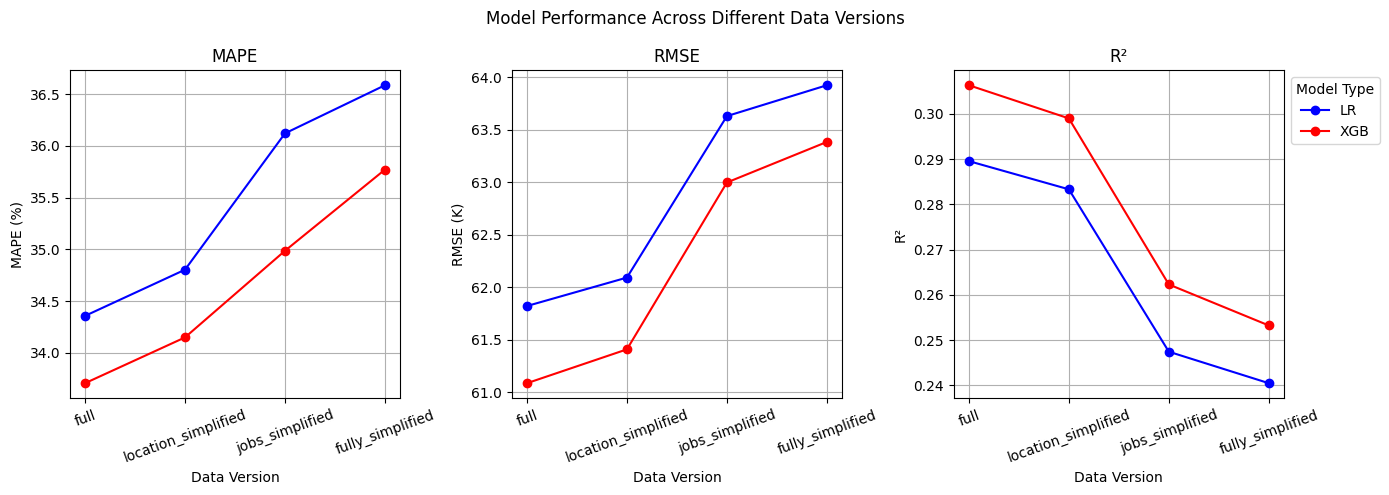

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define colors for models
model_colors = {"LR": "blue", "XGB": "red"}

# Map consistent x-axis labels
x_axis_labels = ["full_data", "location_simplified", "jobs_simplified", "fully_simplified"]

# Assign standard x-axis labels to the DataFrame
lr_results_df["Data Version"] = x_axis_labels
xgb_results_df["Data Version"] = x_axis_labels

# Combine results
df_results = pd.concat([lr_results_df, xgb_results_df])

# Define metrics
metrics = ["MAPE", "RMSE", "R²"]
y_labels = ["MAPE (%)", "RMSE (K)", "R²"]
scaling_factors = [1, 1e-3, 1]  # Convert RMSE to thousands (K)

plt.figure(figsize=(14, 5))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)

    for model_type, color in model_colors.items():
        subset = df_results[df_results["Model"].str.startswith(model_type)]
        plt.plot(x_axis_labels, subset[metric] * scaling_factors[i], marker='o', linestyle='-', color=color, label=model_type)

    plt.xlabel("Data Version")
    plt.ylabel(y_labels[i])
    plt.title(metric)  # Only the metric name
    plt.xticks(x_axis_labels, rotation=20)
    plt.grid(True)

# Add a single legend
plt.legend(title="Model Type", loc='upper left', bbox_to_anchor=(1, 1))
plt.suptitle("Model Performance Across Different Data Versions")
plt.tight_layout()
plt.show()


Our tests with Linear Regression and XGBoost on different dataset variations clearly indicate that reducing categorical details (job titles, country locations) consistently reduces model performance.

🔍 Key Findings:
1️⃣ Retaining full categorical details results in the best performance.

Highest R² (0.306 with XGBoost, 0.289 with Linear Regression).
Lowest RMSE and MAPE, indicating more accurate salary predictions.
2️⃣ Simplifying locations (countries → continents) has a small negative impact.

Slight increase in RMSE & drop in R².
Conclusion: Countries likely hold some salary-related information, but the loss is minor.
3️⃣ Simplifying job titles (using clusters) results in a bigger performance drop.

Higher RMSE, worse MAPE, and lower R².
Conclusion: Job title granularity is highly relevant for salary prediction.
4️⃣ Fully simplifying both job titles & locations leads to the worst performance.

Likely due to the loss of crucial salary-related variance in the data.


🚀 Conclusion:

📌 Reducing categorical details significantly lowers model explainability (R² decreases).

📌 The more we generalize job titles and locations, the more salary variations we lose.

📌 For the best predictive performance, we should retain as much categorical detail as possible.

